# Visualize Results of Trained Models

This demo loads trained models and runs a number of visualizations including comparing the output of two models, looking at individual convolution filter, and comparing input channel ablation.

In [1]:
from deeplab3.dataloaders import make_dataset
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from deeplab3.utils import model_utils
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math, os

from types import SimpleNamespace

### Configuration 

Primary Model

In [2]:
model_name = 'RGBD'
cfg_filepath = '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml'
cfg_list = []

cfg = model_utils.match_cfg_versions(cfg_filepath)
cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                     'TEST.MAX_ITER', 1000,
                     'MODEL.PRETRAINED', "",
                     'SYSTEM.GPU_IDS', [0]])
cfg.merge_from_list(cfg_list)

Non-existent key: DATASET.CITYSCAPES.TEST_SET


/home/cecilia/pytorch-deeplab-xception/deeplab3/utils/model_utils.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  model_cfg = yaml.load(f)


Dataset

In [10]:
# Dataset directory root
root = '../datasets/cityscapes/'

cfg2 = cfg.clone()

dataset_name = "Completed Depth"
cfg.merge_from_list(['DATASET.ROOT', root,
                    'DATASET.CITYSCAPES.DEPTH_DIR', 'completed_depth'])
dataset = make_dataset(cfg, 'val')

dataset_name2 = "RGBD"
cfg2.merge_from_list(['DATASET.ROOT', root])
dataset2 = make_dataset(cfg2, 'val')

Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images


Load a saved model and visualize results
-----

The trained model takes an image input and produces a segmentation mask. In this section, we look at the different segmentation masks produced by the primary and comparison models.

In [11]:
import torch
import os
from deeplab3.dataloaders import make_data_loader
from deeplab3.modeling.sync_batchnorm.replicate import patch_replication_callback
from deeplab3.modeling.deeplab import *

In [12]:
## Load saved model
def load_model(cfg):
    """Loads a saved model from a checkpoint"""
    model = DeepLab(cfg)

    if cfg.SYSTEM.CUDA:
        model = torch.nn.DataParallel(model, device_ids=cfg.SYSTEM.GPU_IDS)
        patch_replication_callback(model)
        model = model.cuda()

    model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
    
    if not os.path.isfile(model_filepath):
        raise RuntimeError("=> no checkpoint found at '{}'" .format(model_filepath))
    checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
    cfg.TRAIN.START_EPOCH = checkpoint['epoch']
    if cfg.SYSTEM.CUDA:
        model.module.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint['state_dict'])
    best_pred = checkpoint['best_pred']
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(cfg.CHECKPOINT.DIRECTORY, checkpoint['epoch']))
    return model

In [13]:
# Load the primary model
model = load_model(cfg)
model.eval()

Training backbone from scratch
=> loaded checkpoint '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16' (epoch 1)


DataParallel(
  (module): DeepLab(
    (backbone): AlignedXception(
      (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (rep): Sequential(
          (0): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (pointwise): Conv2d(64, 128, 

In [14]:
def display_results(cfg, loader, image, target, image2=None):
    if cfg.SYSTEM.CUDA:
        image, target = image.cuda(), target.cuda()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    
    image = image.cpu()
    target = target.cpu().numpy()
    
    pred = output.data.cpu().squeeze().numpy()
    pred = np.argmax(pred, axis=0)
    
    if image2 is not None:
        if cfg.SYSTEM.CUDA:
            image2 = image2.cuda()
        with torch.no_grad():
            output2 = model(image2.unsqueeze(0))
        pred2 = output2.data.cpu().squeeze().numpy()
        pred2 = np.argmax(pred2, axis=0)
        
    img_tmp = loader.invert_normalization(image)

    segmap = decode_segmap(target, dataset=cfg.DATASET.NAME)
    segmap_pred = decode_segmap(pred, dataset=cfg.DATASET.NAME)

    plt.figure(figsize=(16, 4))
    plt.subplot(151)
    plt.imshow(img_tmp[:,:,:3])
    plt.title('RGB')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(img_tmp[:,:,3])
    plt.title('Depth')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(segmap) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title('GT')
    plt.axis('off')

    plt.subplot(154)
    plt.imshow(segmap_pred) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title(dataset_name + ' Prediction')
    plt.axis('off')

    if image2 is not None:
        segmap2 = decode_segmap(pred2, dataset=cfg.DATASET.NAME)
        plt.subplot(155)
        plt.imshow(segmap2) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title(dataset_name2 + ' Prediction')
        plt.axis('off')


['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


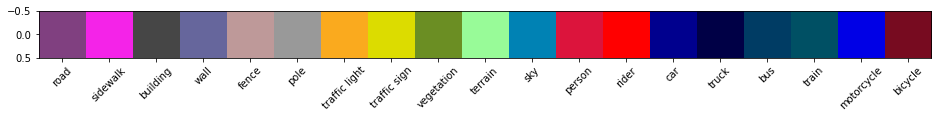

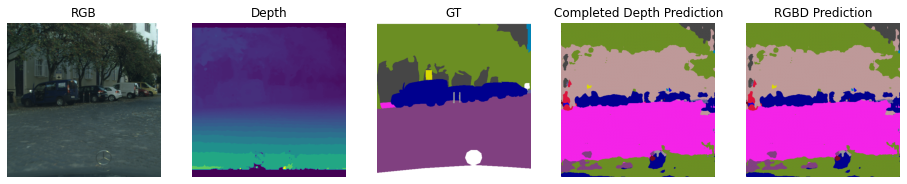

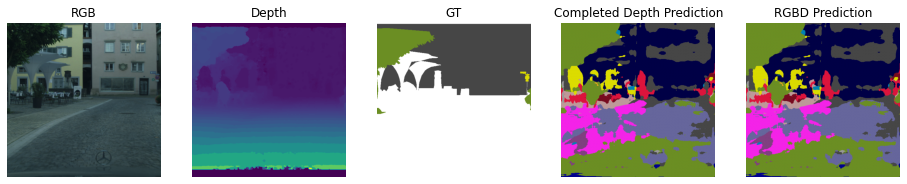

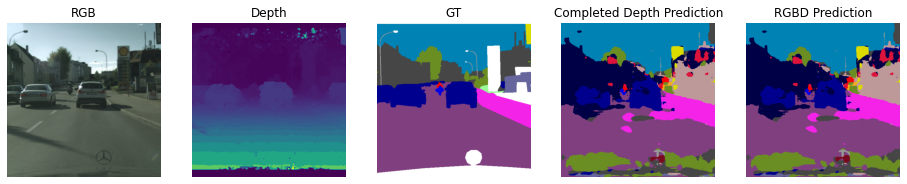

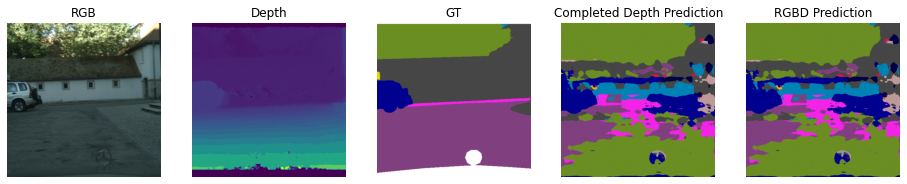

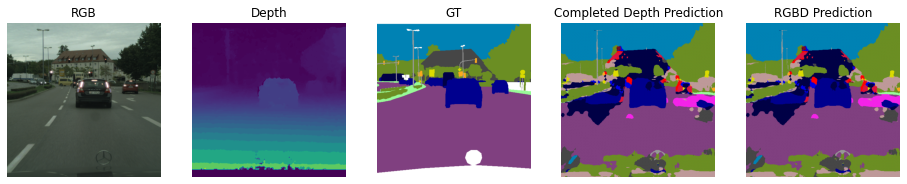

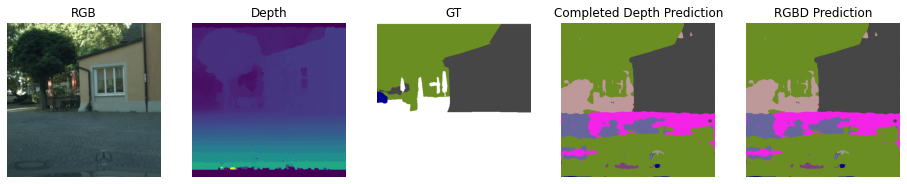

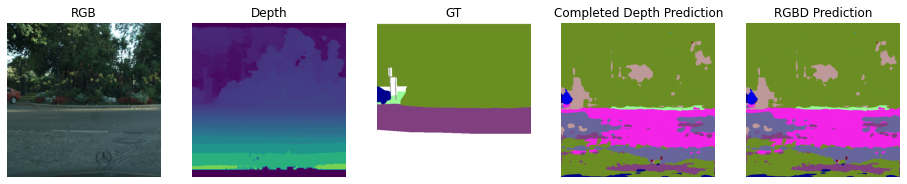

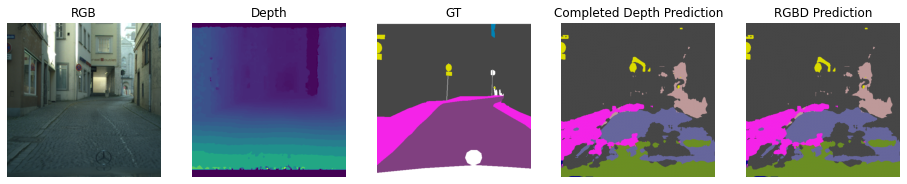

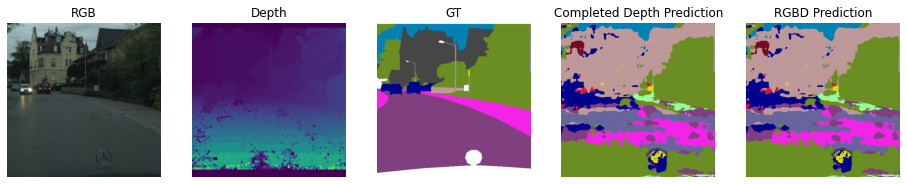

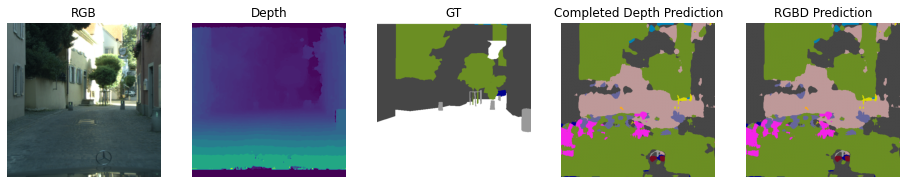

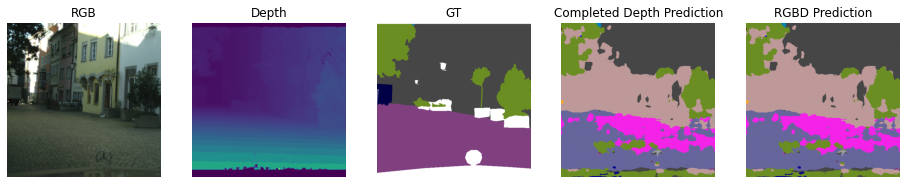

In [15]:
from deeplab3.dataloaders import get_label_colors

#Class colors for reference
labels = [x.replace('_', ' ') for x in dataset.loader.class_names]

plt.figure(figsize=(16, 1))
plt.imshow(np.expand_dims(get_label_colors(cfg), 0))
plt.xticks(range(len(labels)), labels, rotation=45)
print(labels)

# Test images 

for ii, sample in enumerate(dataset):
    image, target = sample['image'], sample['label']
    image2 = dataset2[ii]['image']
    display_results(cfg, dataset.loader, image, target, image2)
    
    if ii==10:
        break

plt.show(block=True)
